<a href="https://colab.research.google.com/github/hanghae-plus-AI/AI-1-hyeondata/blob/main/Chapter1_2_%EA%B3%BC%EC%A0%9CB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer 실습

이번 실습에서는 감정 분석 task에 RNN 대신 Transformer를 구현하여 적용해 볼 것입니다.
Library import나 dataloader 생성은 RNN 실습 때와 똑같기 때문에 설명은 넘어가도록 하겠습니다.

In [1]:
!pip install datasets|

/bin/bash: -c: line 2: syntax error: unexpected end of file


In [2]:
!pip install sacremoses
# 아래 코드 실행 시 RuntimeError: Missing dependencies: sacremoses 에러가 나서 추가

In [3]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)


ds = load_dataset("stanfordnlp/imdb")
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')


def collate_fn(batch):
  max_len = 400
  texts, labels = [], []
  for row in batch:
    labels.append(row['label'])
    texts.append(row['text'])

  texts = torch.LongTensor(tokenizer(texts, padding=True, truncation=True, max_length=max_len).input_ids)
  labels = torch.LongTensor(labels)

  return texts, labels


train_loader = DataLoader(
    ds['train'], batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    ds['test'], batch_size=64, shuffle=False, collate_fn=collate_fn
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## Self-attention

이번에는 self-attention을 구현해보겠습니다.
Self-attention은 shape이 (B, S, D)인 embedding이 들어왔을 때 attention을 적용하여 새로운 representation을 만들어내는 module입니다.
여기서 B는 batch size, S는 sequence length, D는 embedding 차원입니다.
구현은 다음과 같습니다.

In [3]:
from torch import nn
from math import sqrt


class SelfAttention(nn.Module):
  def __init__(self, input_dim, d_model):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model

    self.wq = nn.Linear(input_dim, d_model)
    self.wk = nn.Linear(input_dim, d_model)
    self.wv = nn.Linear(input_dim, d_model)
    self.dense = nn.Linear(d_model, d_model)

    self.softmax = nn.Softmax(dim=-1)

  def forward(self, x, mask):
    q, k, v = self.wq(x), self.wk(x), self.wv(x)
    score = torch.matmul(q, k.transpose(-1, -2)) # (B, S, D) * (B, D, S) = (B, S, S)
    score = score / sqrt(self.d_model)

    if mask is not None:
      score = score + (mask * -1e9)

    score = self.softmax(score)
    result = torch.matmul(score, v)
    result = self.dense(result)

    return result

대부분은 Transformer 챕터에서 배운 수식들을 그대로 구현한 것에 불과합니다.
차이점은 `mask`의 존재여부입니다.
이전 챕터에서 우리는 가변적인 text data들에 padding token을 붙여 하나의 matrix로 만든 방법을 배웠습니다.
실제 attention 계산에서는 이를 무시해주기 위해 mask를 만들어 제공해주게 됩니다.
여기서 mask의 shape은 (B, S, 1)로, 만약 `mask[i, j] = True`이면 그 변수는 padding token에 해당한다는 뜻입니다.
이러한 값들을 무시해주는 방법은 shape이 (B, S, S)인 `score`가 있을 때(수업에서 배운 $A$와 동일) `score[i, j]`에 아주 작은 값을 더해주면 됩니다. 아주 작은 값은 예를 들어 `-1000..00 = -1e9` 같은 것이 있습니다.
이렇게 작은 값을 더해주고 나면 softmax를 거쳤을 때 0에 가까워지기 때문에 weighted sum 과정에서 padding token에 해당하는 `v` 값들을 무시할 수 있게 됩니다.

다음은 self-attention과 feed-forward layer를 구현한 모습입니다.

In [5]:
class TransformerLayer(nn.Module):
  def __init__(self, input_dim, d_model, dff):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model
    self.dff = dff

    self.sa = SelfAttention(input_dim, d_model)
    self.ffn = nn.Sequential(
      nn.Linear(d_model, dff),
      nn.ReLU(),
      nn.Linear(dff, d_model)
    )

  def forward(self, x, mask):
    x = self.sa(x, mask)
    x = self.ffn(x)

    return x

보시다시피 self-attention의 구현이 어렵지, Transformer layer 하나 구현하는 것은 수업 때 다룬 그림과 크게 구분되지 않는다는 점을 알 수 있습니다.

## Positional encoding

이번에는 positional encoding을 구현합니다. Positional encoding의 식은 다음과 같습니다:
$$
\begin{align*} PE_{pos, 2i} &= \sin\left( \frac{pos}{10000^{2i/D}} \right), \\ PE_{pos, 2i+1} &= \cos\left( \frac{pos}{10000^{2i/D}} \right).\end{align*}
$$

이를 Numpy로 구현하여 PyTorch tensor로 변환한 모습은 다음과 같습니다:

In [6]:
import numpy as np


def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)


max_len = 400
print(positional_encoding(max_len, 256).shape)

torch.Size([1, 400, 256])


Positional encoding은 `angle_rads`를 구현하는 과정에서 모두 구현이 되었습니다. 여기서 `angle_rads`의 shape은 (S, D)입니다.
우리는 일반적으로 batch로 주어지는 shape이 (B, S, D)인 tensor를 다루기 때문에 마지막에 None을 활용하여 shape을 (1, S, D)로 바꿔주게됩니다.

위에서 구현한 `TransformerLayer`와 positional encoding을 모두 합친 모습은 다음과 같습니다:

In [7]:
class TextClassifier(nn.Module):
  def __init__(self, vocab_size, d_model, n_layers, dff):
    super().__init__()

    self.vocab_size = vocab_size
    self.d_model = d_model
    self.n_layers = n_layers
    self.dff = dff

    self.embedding = nn.Embedding(vocab_size, d_model)
    self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
    self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff) for _ in range(n_layers)])
    self.classification = nn.Linear(d_model, 1)

  def forward(self, x):
    mask = (x == tokenizer.pad_token_id)
    mask = mask[:, None, :]
    seq_len = x.shape[1]

    x = self.embedding(x)
    x = x * sqrt(self.d_model)
    x = x + self.pos_encoding[:, :seq_len]

    for layer in self.layers:
      x = layer(x, mask)

    x = x[:, 0]
    x = self.classification(x)

    return x


model = TextClassifier(len(tokenizer), 32, 2, 32)

기존과 다른 점들은 다음과 같습니다:
1. `nn.ModuleList`를 사용하여 여러 layer의 구현을 쉽게 하였습니다.
2. Embedding, positional encoding, transformer layer를 거치고 난 후 마지막 label을 예측하기 위해 사용한 값은 `x[:, 0]`입니다. 기존의 RNN에서는 padding token을 제외한 마지막 token에 해당하는 representation을 사용한 것과 다릅니다. 이렇게 사용할 수 있는 이유는 attention 과정을 보시면 첫 번째 token에 대한 representation은 이후의 모든 token의 영향을 받습니다. 즉, 첫 번째 token 또한 전체 문장을 대변하는 의미를 가지고 있다고 할 수 있습니다. 그래서 일반적으로 Transformer를 text 분류에 사용할 때는 이와 같은 방식으로 구현됩니다.

## 학습

학습하는 코드는 기존 실습들과 동일하기 때문에 마지막 결과만 살펴보도록 하겠습니다.

In [8]:
from torch.optim import Adam

lr = 0.001
model = model.to('cuda')
loss_fn = nn.BCEWithLogitsLoss()

optimizer = Adam(model.parameters(), lr=lr)

In [10]:
import numpy as np
import matplotlib.pyplot as plt


def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    # preds = torch.argmax(preds, dim=-1)
    preds = (preds > 0).long()[..., 0]

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

In [10]:
n_epochs = 50

for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda').float()

    preds = model(inputs)[..., 0]
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

  with torch.no_grad():
    model.eval()
    train_acc = accuracy(model, train_loader)
    test_acc = accuracy(model, test_loader)
    print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

Epoch   0 | Train Loss: 242.20440170168877
=========> Train acc: 0.744 | Test acc: 0.718
Epoch   1 | Train Loss: 185.22721248865128
=========> Train acc: 0.821 | Test acc: 0.773
Epoch   2 | Train Loss: 156.0751973837614
=========> Train acc: 0.859 | Test acc: 0.791
Epoch   3 | Train Loss: 132.0757782906294
=========> Train acc: 0.882 | Test acc: 0.795
Epoch   4 | Train Loss: 112.07879155874252
=========> Train acc: 0.904 | Test acc: 0.792
Epoch   5 | Train Loss: 95.62841914594173
=========> Train acc: 0.934 | Test acc: 0.798
Epoch   6 | Train Loss: 78.65711183100939
=========> Train acc: 0.948 | Test acc: 0.797
Epoch   7 | Train Loss: 63.71846041828394
=========> Train acc: 0.962 | Test acc: 0.798
Epoch   8 | Train Loss: 50.561754047870636
=========> Train acc: 0.974 | Test acc: 0.795
Epoch   9 | Train Loss: 39.95337771065533
=========> Train acc: 0.973 | Test acc: 0.786
Epoch  10 | Train Loss: 31.669904701411724
=========> Train acc: 0.976 | Test acc: 0.790
Epoch  11 | Train Loss: 27.

학습이 안정적으로 진행되며 RNN보다 빨리 수렴하는 것을 확인할 수 있습니다.
하지만 test 정확도가 RNN보다 낮은 것을 보았을 때, overfitting에 취약하다는 것을 알 수 있습니다.

# 과제 B. 주어진 문장에서 나올 다음 단어를 예측하는 모델 구현

-  Last word prediction dataset 준비
    - 기존의 IMDB dataset을 그대로 활용합니다.
    - `collate_fn` 함수에 다음 수정사항들을 반영하면 됩니다.
        - Label은 text를 token으로 변환했을 때 마지막에서 두 번째 token의 id로 설정합니다.
        - 입력 data는 마지막 두 token을 제외한 나머지 token들의 list로 설정합니다.
    - `from torch.nn.utils.rnn import pad_sequence`를 import해서 사용하셔도 좋습니다.
    - Truncation은 기존과 똑같이 진행하시면 됩니다.
-  Loss function 및 classifier output 변경
    - 마지막 token id를 예측하는 것이기 때문에 binary classification이 아닌 일반적인 classification 문제로 바뀝니다. MNIST 과제에서 했던 것 처럼 `nn.CrossEntropy` loss와 `TextClassifier`의 출력 차원을 잘 조정하여 task를 풀 수 있도록 수정하시면 됩니다.
-  학습 결과 report
    - 과제 A에서 사용한 것과 동일한 모델로 last word prediction을 학습하시면 됩니다.

### collate_fn 함수에 다음 수정사항들을 반영
Label은 text를 token으로 변환했을 때 마지막에서 두 번째 token의 id로 설정합니다.
입력 data는 마지막 두 token을 제외한 나머지 token들의 list로 설정합니다.

In [4]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast
from torch.nn.utils.rnn import pad_sequence

from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)


ds = load_dataset("stanfordnlp/imdb")
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')


def collate_fn(batch):
  max_len = 400
  texts, labels = [], []

  for row in batch:
    tokens = tokenizer(row['text'], padding=True, truncation=True, max_length=max_len).input_ids # 토큰화
    labels.append(tokens[-2]) # 마지막에서 두 번째 token의 id로 설정
    texts.append(tokens[:-2]) # 마지막에서 두 번째 token의 id로 설정

  # pad_sequence 함수를 사용하여 padding처리
  texts = pad_sequence([torch.LongTensor(text) for text in texts], batch_first=True, padding_value=tokenizer.pad_token_id)
  labels = torch.LongTensor(labels)


  return texts, labels


train_loader = DataLoader(
    ds['train'], batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    ds['test'], batch_size=64, shuffle=False, collate_fn=collate_fn
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## 이전에 사용하는 모델 그대로 생성

In [5]:
from torch import nn
from math import sqrt


class MultiHeadAttention(nn.Module):
  def __init__(self, input_dim, d_model,num_heads):
    super().__init__()


    assert d_model % num_heads == 0, "d_model must be divisible by num_heads" # 제약 조건 D = H * D'

    self.input_dim = input_dim
    self.d_model = d_model
    self.num_heads = num_heads    # head 개수
    self.head_dim = d_model // num_heads  # 모델 차원에서 어텐션 헤드 수 만큼 나눠서 떨어지는 값 변수

    self.wq = nn.Linear(input_dim, d_model)
    self.wk = nn.Linear(input_dim, d_model)
    self.wv = nn.Linear(input_dim, d_model)
    self.dense = nn.Linear(d_model, d_model)

    self.softmax = nn.Softmax(dim=-1)


  def forward(self, x, mask):

    batch_size, seq_length, _ = x.size()

    q = self.wq(x).view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2) # (B, H, S, D')
    k = self.wk(x).view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2) # (B, H, S, D')
    v = self.wv(x).view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2) # (B, H, S, D')


    score = torch.matmul(q, k.transpose(-1, -2))  # (B, H, S, S)
    score = score / sqrt(self.d_model)

    if mask is not None:
      mask = mask.unsqueeze(1)
      score = score + (mask * -1e9)

    score = self.softmax(score)
    result = torch.matmul(score, v)

    result = result.transpose(1, 2).contiguous()  # (batch_size, seq_len, n_heads, depth)
    result = result.view(batch_size, -1, self.d_model)

    result = self.dense(result)

    return result

In [6]:
class TransformerLayer(nn.Module):
  def __init__(self, input_dim, d_model, dff, num_heads, dropout=0.1):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model
    self.dff = dff

    self.mha = MultiHeadAttention(input_dim, d_model, num_heads)
    self.sa = SelfAttention(input_dim, d_model)
    self.ffn = nn.Sequential(
      nn.Linear(d_model, dff),
      nn.ReLU(),
      nn.Linear(dff, d_model)
    )
    self.layernome = nn.LayerNorm(d_model)
    self.dropout = nn.Dropout(dropout)


  def forward(self, x, mask):
    x1 = self.mha(x, mask)
    x1 = self.dropout(x1)
    x1 = self.layernome(x1 + x)

    x2 = self.ffn(x1)
    x2 = self.dropout(x2)
    x2 = self.layernome(x2 + x1)

    return x2

In [7]:
import numpy as np


def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)


max_len = 400
print(positional_encoding(max_len, 256).shape)

torch.Size([1, 400, 256])


## 학습 전 Loss function 및 classifier output 변경

### classifier output 변경

In [8]:
class TextClassifier(nn.Module):
  def __init__(self, vocab_size, d_model, n_layers, dff, n_heads):
    super().__init__()

    self.vocab_size = vocab_size
    self.d_model = d_model
    self.n_layers = n_layers
    self.dff = dff

    self.embedding = nn.Embedding(vocab_size, d_model)
    self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
    self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff, n_heads) for _ in range(n_layers)])
    self.classification = nn.Linear(d_model, vocab_size)

  def forward(self, x):
    mask = (x == tokenizer.pad_token_id)
    mask = mask[:, None, :]
    seq_len = x.shape[1]

    x = self.embedding(x)
    x = x * sqrt(self.d_model)
    x = x + self.pos_encoding[:, :seq_len]

    for layer in self.layers:
      x = layer(x, mask)

    x = x[:, 0]
    x = self.classification(x)

    return x




### Loss function 변경

In [9]:
from torch.optim import Adam

model = TextClassifier(len(tokenizer), 32, 5, 32, 4)

lr = 0.001
model = model.to('cuda')
loss_fn = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(), lr=lr)

In [10]:
import numpy as np
import matplotlib.pyplot as plt


def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)
    # preds = (preds > 0).long()[..., 0]

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

## 학습

In [11]:
n_epochs = 50
train_acc_list = []
test_acc_list = []

for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

  with torch.no_grad():
    model.eval()
    train_acc = accuracy(model, train_loader)
    test_acc = accuracy(model, test_loader)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")


Epoch   0 | Train Loss: 1613.5347076654434
=========> Train acc: 0.558 | Test acc: 0.564
Epoch   1 | Train Loss: 1093.42353785038
=========> Train acc: 0.562 | Test acc: 0.568
Epoch   2 | Train Loss: 1041.3339952230453
=========> Train acc: 0.565 | Test acc: 0.568
Epoch   3 | Train Loss: 1010.1270005702972
=========> Train acc: 0.572 | Test acc: 0.567
Epoch   4 | Train Loss: 983.1121326684952
=========> Train acc: 0.577 | Test acc: 0.564
Epoch   5 | Train Loss: 959.0938866138458
=========> Train acc: 0.582 | Test acc: 0.558
Epoch   6 | Train Loss: 931.5368548631668
=========> Train acc: 0.583 | Test acc: 0.557
Epoch   7 | Train Loss: 903.3898643255234
=========> Train acc: 0.602 | Test acc: 0.554
Epoch   8 | Train Loss: 873.421527504921
=========> Train acc: 0.624 | Test acc: 0.522
Epoch   9 | Train Loss: 836.8851833343506
=========> Train acc: 0.626 | Test acc: 0.545
Epoch  10 | Train Loss: 802.2554181814194
=========> Train acc: 0.646 | Test acc: 0.538
Epoch  11 | Train Loss: 764.608

### train과 test의 acc를 plot 표시

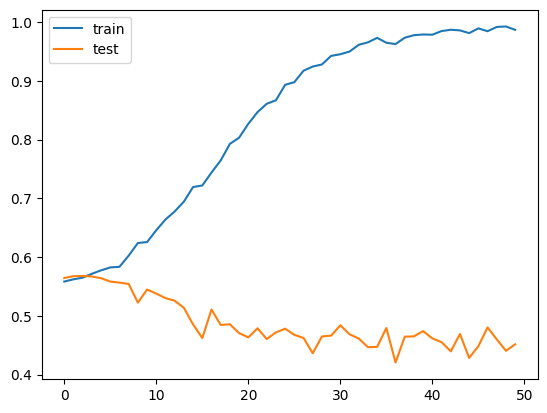

In [12]:
import numpy as np
#Epoch에 따른 SGD와 Adam optimizer의 trainSet에 대한 model의 정확도를 다음 코드를 사용하여 plot하는 함수
def plot_acc(trainloader_acc, testloader_acc, label1='train', label2='test'):
  x = np.arange(len(trainloader_acc))

  plt.plot(x, trainloader_acc, label=label1)
  plt.plot(x, testloader_acc, label=label2)
  plt.legend()
  plt.show()

# plot하는 함수 사용
plot_acc(train_acc_list, test_acc_list)

### 분석
위의 표로 보아 10 epoch 이후에는 train데이터 셋에 과적합하는 현상을 보이며, test셋의 정확도가 떨어지는 현상이 보인다.

## 성능 개선을 위한 내부 차원 변경 시도
( 차원 32 -> 64로 변경 )

In [25]:
from torch.optim import Adam

model = TextClassifier(len(tokenizer), 64, 5, 64, 4) #  차원 32 -> 64로 변경

lr = 0.001
model = model.to('cuda')
loss_fn = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(), lr=lr)

In [26]:
import numpy as np
import matplotlib.pyplot as plt


def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)
    # preds = (preds > 0).long()[..., 0]

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

## 학습

In [27]:
n_epochs = 50
train_acc_list64 = []
test_acc_list64 = []
for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

  with torch.no_grad():
    model.eval()
    train_acc = accuracy(model, train_loader)
    test_acc = accuracy(model, test_loader)
    train_acc_list64.append(train_acc)
    test_acc_list64.append(test_acc)
    print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

Epoch   0 | Train Loss: 1407.0731209516525
=========> Train acc: 0.558 | Test acc: 0.563
Epoch   1 | Train Loss: 1088.7366757392883
=========> Train acc: 0.558 | Test acc: 0.562
Epoch   2 | Train Loss: 1038.3105891942978
=========> Train acc: 0.557 | Test acc: 0.549
Epoch   3 | Train Loss: 1010.2134908437729
=========> Train acc: 0.568 | Test acc: 0.565
Epoch   4 | Train Loss: 984.9803314208984
=========> Train acc: 0.571 | Test acc: 0.550
Epoch   5 | Train Loss: 961.4214934110641
=========> Train acc: 0.575 | Test acc: 0.562
Epoch   6 | Train Loss: 938.6579290628433
=========> Train acc: 0.580 | Test acc: 0.559
Epoch   7 | Train Loss: 915.8488150835037
=========> Train acc: 0.579 | Test acc: 0.555
Epoch   8 | Train Loss: 891.4991308450699
=========> Train acc: 0.587 | Test acc: 0.559
Epoch   9 | Train Loss: 866.906555891037
=========> Train acc: 0.589 | Test acc: 0.555
Epoch  10 | Train Loss: 838.7794990539551
=========> Train acc: 0.592 | Test acc: 0.552
Epoch  11 | Train Loss: 810.4

### train과 test의 acc를 plot 표시

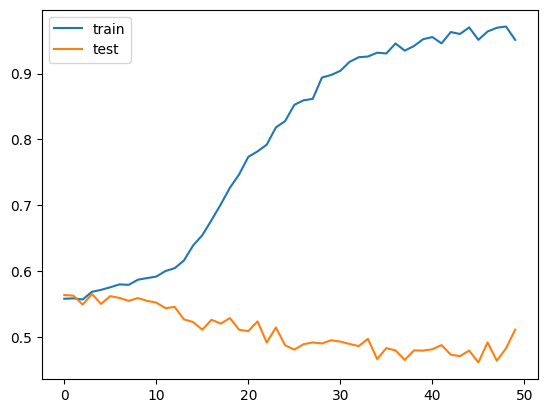

In [28]:
import numpy as np
#Epoch에 따른 SGD와 Adam optimizer의 trainSet에 대한 model의 정확도를 다음 코드를 사용하여 plot하는 함수
def plot_acc(trainloader_acc, testloader_acc, label1='train', label2='test'):
  x = np.arange(len(trainloader_acc))

  plt.plot(x, trainloader_acc, label=label1)
  plt.plot(x, testloader_acc, label=label2)
  plt.legend()
  plt.show()

# plot하는 함수 사용
plot_acc(train_acc_list64, test_acc_list64)

### 분석
모델의 차원을 32-> 64 늘렸지만 이전에 32 차원이랑 거의 비슷하게 위의 표처럼 10 epoch 이후에는 train데이터 셋에 과적합하는 현상을 보이며, test셋의 정확도가 떨어지는 현상이 보인다.

### 추후 과제
시간 관계상 더 테스트를 해보지는 못 했지만 더 높은 차원을 이용하여 테스트 또는 다른 파라미터도 조절하여 test성능을 높이는데 시도를 해보아야 할 것 같다.
